In [ ]:
import os
import numpy as np
from sklearn.cluster import DBSCAN
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from ground_truth import GROUND_TRUTH, GROUND_TRUTH_BRANDS, GROUND_TRUTH_CREATORS

COLLAB_DIR = "/home/yash-sisodia/face-detection/collaborators_india/collaborators"

def normalize(vec):
    norm = np.linalg.norm(vec)
    return vec / norm if norm > 0 else vec

eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
cos_values = [0.5, 0.6, 0.7, 0.8, 0.9]
face_ratios = [0.3, 0.4]
cluster_ratios = [0.3, 0.4]

embedding_files = {
    "MS1MV2": "embeddings_ms1mv2.npz",
    "Glint360K": "embeddings_glint360k.npz"
}

results = {name: [] for name in embedding_files}
failed_cases = []

for model_name, emb_file in embedding_files.items():
    print(f"\n=== Evaluating {model_name} embeddings ===")
    for eps in eps_values:
        for cos_thr in cos_values:
            for fr_thr in face_ratios:
                for cr_thr in cluster_ratios:
                    correct = 0
                    total = 0

                    for USERNAME in [u for u in os.listdir(COLLAB_DIR) if u in GROUND_TRUTH]:
                        embeddings_file = next(
                            (p for p in (
                                os.path.join(COLLAB_DIR, USERNAME, "embeddings_ms1mv2.npz"),
                                os.path.join(COLLAB_DIR, USERNAME, "embeddings_glint360k.npz")
                            ) if os.path.exists(p)),
                            None
                        )
                        if embeddings_file is None:
                            continue

                        data = np.load(embeddings_file, allow_pickle=True)
                        prof_emb = data["profile_embeddings"]
                        thumb_emb = data["thumbnail_embeddings"]
                        if thumb_emb.size == 0:
                            continue

                        thumb_emb = np.array([normalize(e) for e in thumb_emb])
                        clustering = DBSCAN(eps=eps, min_samples=2, metric="cosine").fit(thumb_emb)
                        labels = clustering.labels_

                        clusters = defaultdict(list)
                        for i, label in enumerate(labels):
                            if label != -1:
                                clusters[label].append(thumb_emb[i])

                        prediction = "NON-HUMAN"
                        if len(clusters) > 0:
                            centroids = {cid: np.mean(vectors, axis=0) for cid, vectors in clusters.items()}
                            total_faces = len(thumb_emb)

                            if prof_emb.size > 0:
                                prof_vec = normalize(prof_emb[0])
                                sims = {cid: cosine_similarity([prof_vec], [cent])[0,0] for cid, cent in centroids.items()}
                                best = [cid for cid, s in sims.items() if s > cos_thr]
                                if len(best) == 1:
                                    cid = best[0]
                                    face_ratio = len(clusters[cid]) / total_faces
                                    cluster_ratio = len(clusters[cid]) / sum(len(v) for v in clusters.values())
                                    if face_ratio >= fr_thr and cluster_ratio >= cr_thr:
                                        prediction = "HUMAN"
                            else:
                                for cid, vectors in clusters.items():
                                    face_ratio = len(vectors) / total_faces
                                    cluster_ratio = len(vectors) / sum(len(v) for v in clusters.values())
                                    if face_ratio >= fr_thr and cluster_ratio >= cr_thr:
                                        prediction = "HUMAN"
                                        break

                        truth = "HUMAN" if USERNAME in GROUND_TRUTH_CREATORS else "NON-HUMAN"
                        if prediction == truth:
                            correct += 1
                        else:
                            failed_cases.append({
                                "username": USERNAME,
                                "truth": truth,
                                "pred": prediction,
                                "eps": eps,
                                "cos": cos_thr,
                                "fr": fr_thr,
                                "cr": cr_thr,
                                "model": model_name
                            })
                        total += 1

                    acc = correct / total if total else 0
                    results[model_name].append((eps, cos_thr, fr_thr, cr_thr, acc))
                    print(f"{model_name}: eps={eps}, cos={cos_thr}, face_r={fr_thr}, cluster_r={cr_thr} -> acc={acc:.2f}")

best = max((x for res in results.values() for x in res), key=lambda x: x[4])
print("\nBest params:", best)

eps_b, cos_b, fr_b, cr_b, acc_b = best
best_failures = [
    f for f in failed_cases
    if (f["eps"], f["cos"], f["fr"], f["cr"]) == (eps_b, cos_b, fr_b, cr_b)
]

print(f"\n{len(best_failures)} failures out of {int(len(best_failures)+acc_b*len(best_failures)/(1-acc_b))}")
print("Some failed usernames and predictions:")
for f in best_failures[:20]:
    print(f"{f['username']}")


=== Evaluating MS1MV2 embeddings ===
MS1MV2: eps=0.1, cos=0.5, face_r=0.3, cluster_r=0.3 -> acc=0.39
MS1MV2: eps=0.1, cos=0.5, face_r=0.3, cluster_r=0.4 -> acc=0.39
MS1MV2: eps=0.1, cos=0.5, face_r=0.4, cluster_r=0.3 -> acc=0.39
MS1MV2: eps=0.1, cos=0.5, face_r=0.4, cluster_r=0.4 -> acc=0.39
MS1MV2: eps=0.1, cos=0.6, face_r=0.3, cluster_r=0.3 -> acc=0.39
MS1MV2: eps=0.1, cos=0.6, face_r=0.3, cluster_r=0.4 -> acc=0.39
MS1MV2: eps=0.1, cos=0.6, face_r=0.4, cluster_r=0.3 -> acc=0.39
MS1MV2: eps=0.1, cos=0.6, face_r=0.4, cluster_r=0.4 -> acc=0.39
MS1MV2: eps=0.1, cos=0.7, face_r=0.3, cluster_r=0.3 -> acc=0.39
MS1MV2: eps=0.1, cos=0.7, face_r=0.3, cluster_r=0.4 -> acc=0.39
MS1MV2: eps=0.1, cos=0.7, face_r=0.4, cluster_r=0.3 -> acc=0.39
MS1MV2: eps=0.1, cos=0.7, face_r=0.4, cluster_r=0.4 -> acc=0.39
MS1MV2: eps=0.1, cos=0.8, face_r=0.3, cluster_r=0.3 -> acc=0.39
MS1MV2: eps=0.1, cos=0.8, face_r=0.3, cluster_r=0.4 -> acc=0.39
MS1MV2: eps=0.1, cos=0.8, face_r=0.4, cluster_r=0.3 -> acc=0.39
MS

In [2]:
import os
import numpy as np
from sklearn.cluster import DBSCAN
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from ground_truth import GROUND_TRUTH, GROUND_TRUTH_BRANDS, GROUND_TRUTH_CREATORS

COLLAB_DIR = "/home/yash-sisodia/face-detection/collaborators_india/collaborators"


def normalize(vec):
    norm = np.linalg.norm(vec)
    return vec / norm if norm > 0 else vec

eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
cos_values = [0.5, 0.6, 0.7, 0.8, 0.9]
face_ratios = [0.3, 0.4]
cluster_ratios = [0.3, 0.4]

grid_results = []

for eps in eps_values:
    for cos_thr in cos_values:
        for fr_thr in face_ratios:
            for cr_thr in cluster_ratios:
                correct = 0
                total = 0

                for USERNAME in [u for u in os.listdir(COLLAB_DIR) if u in GROUND_TRUTH]:
                    embeddings_file = os.path.join(COLLAB_DIR, USERNAME, "embeddings_output2.npz")
                    if not os.path.exists(embeddings_file):
                        continue

                    data = np.load(embeddings_file, allow_pickle=True)
                    prof_emb = data["profile_embeddings"]
                    thumb_emb = data["thumbnail_embeddings"]
                    if thumb_emb.size == 0:
                        continue

                    thumb_emb = np.array([normalize(e) for e in thumb_emb])
                    clustering = DBSCAN(eps=eps, min_samples=2, metric="cosine").fit(thumb_emb)
                    labels = clustering.labels_

                    clusters = defaultdict(list)
                    for i, label in enumerate(labels):
                        if label != -1:
                            clusters[label].append(thumb_emb[i])

                    prediction = "NON-HUMAN"
                    if len(clusters) > 0:
                        centroids = {cid: np.mean(vectors, axis=0) for cid, vectors in clusters.items()}
                        total_faces = len(thumb_emb)

                        if prof_emb.size > 0:
                            prof_vec = normalize(prof_emb[0])
                            sims = {cid: cosine_similarity([prof_vec], [cent])[0,0] for cid, cent in centroids.items()}
                            best = [cid for cid, s in sims.items() if s > cos_thr]
                            if len(best) == 1:
                                cid = best[0]
                                face_ratio = len(clusters[cid]) / total_faces
                                cluster_ratio = len(clusters[cid]) / sum(len(v) for v in clusters.values())
                                if face_ratio >= fr_thr and cluster_ratio >= cr_thr:
                                    prediction = "HUMAN"
                        else:
                            for cid, vectors in clusters.items():
                                face_ratio = len(vectors) / total_faces
                                cluster_ratio = len(vectors) / sum(len(v) for v in clusters.values())
                                if face_ratio >= fr_thr and cluster_ratio >= cr_thr:
                                    prediction = "HUMAN"
                                    break

                    truth = "HUMAN" if USERNAME in GROUND_TRUTH_CREATORS else "NON-HUMAN"
                    if prediction == truth:
                        correct += 1
                    total += 1

                acc = correct / total if total else 0
                grid_results.append((eps, cos_thr, fr_thr, cr_thr, acc))
                print(f"eps={eps}, cos={cos_thr}, face_r={fr_thr}, cluster_r={cr_thr} -> acc={acc:.2f}")

best = max(grid_results, key=lambda x: x[4])
print("\nBest params:", best)


eps=0.1, cos=0.5, face_r=0.3, cluster_r=0.3 -> acc=0.61
eps=0.1, cos=0.5, face_r=0.3, cluster_r=0.4 -> acc=0.61
eps=0.1, cos=0.5, face_r=0.4, cluster_r=0.3 -> acc=0.61
eps=0.1, cos=0.5, face_r=0.4, cluster_r=0.4 -> acc=0.61
eps=0.1, cos=0.6, face_r=0.3, cluster_r=0.3 -> acc=0.61
eps=0.1, cos=0.6, face_r=0.3, cluster_r=0.4 -> acc=0.61
eps=0.1, cos=0.6, face_r=0.4, cluster_r=0.3 -> acc=0.61
eps=0.1, cos=0.6, face_r=0.4, cluster_r=0.4 -> acc=0.61
eps=0.1, cos=0.7, face_r=0.3, cluster_r=0.3 -> acc=0.61
eps=0.1, cos=0.7, face_r=0.3, cluster_r=0.4 -> acc=0.61
eps=0.1, cos=0.7, face_r=0.4, cluster_r=0.3 -> acc=0.61
eps=0.1, cos=0.7, face_r=0.4, cluster_r=0.4 -> acc=0.61
eps=0.1, cos=0.8, face_r=0.3, cluster_r=0.3 -> acc=0.61
eps=0.1, cos=0.8, face_r=0.3, cluster_r=0.4 -> acc=0.61
eps=0.1, cos=0.8, face_r=0.4, cluster_r=0.3 -> acc=0.61
eps=0.1, cos=0.8, face_r=0.4, cluster_r=0.4 -> acc=0.61
eps=0.1, cos=0.9, face_r=0.3, cluster_r=0.3 -> acc=0.61
eps=0.1, cos=0.9, face_r=0.3, cluster_r=0.4 -> a

In [1]:
import os
import numpy as np
from sklearn.cluster import DBSCAN
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

COLLAB_DIR = "/home/yash-sisodia/face-detection/collaborators_india/collaborators"

GROUND_TRUTH_BRANDS = {
    "mynykaa",
    "nykaanaturals",
    "nykaaskinrx",
    "nykaacosmetics",
    "wowskinscienceindia",
    "mamaearth.in",
    "letspurplle",
    "asabeautyindia",
    "trysugar",
    "nathabit.in",
    "discover.pilgrim",
    "vlccin",
    "forestessentials",
    "faebeautyofficial",
    "thebodyshopindia",
    "lovecolorbar",
    "biotique_world",
    "maccosmeticsindia",
    "revlon_india",
    "bobbibrownindia",
    "himalaya_facecare",
    "plumgoodness",
    "plumbodylovin",
    "disguisecosmetics",
    "myglamm",
    "coloressenceofficial",
    "rubys.organics",
    "elle18_india",
    "livon",
    "herbalessencesindia",
    "thebeautycoindia",
    "loverecode",
    "facescanada",
    "clinique_in",
    "suroskiebeauty",
    "paccosmetic",
    "litcosmeticsindia",
    "beauty_secret_highend_makeup",
    "biodermaindia",
    "mymakeupstory_india",
    "londonprimeindia",
    "charactercosmeticsindia",
    "forever52india",
    "keautybeauty.in",
    "shopaarel",
    "justgoldindia",
    "lashupindia",
    "saturnhealth.ghc",
    "skinkraftshop",
    "marshealth.ghc",
    "beromtnails",
    "blissible_cosmetics",
    "prishebeauty",
    "kindedbeauty",
    "abelia.cares",
    "farmbeautyofficial",
    "ellement.company",
    "skinpassword.in",
    "kaybykatrina",
    "82e.official",
    "arata.in",
    "herbyangelofficial",
    "nutriglowcosmetics",
    "oh_ind",
    "kapiva_official",
    "mcaffeineofficial",
    "perforaofficial",
    "sephora_india",
    "recodeeverydaymakeup",
    "officialswissbeauty",
    "mycosiq",
    "suganda.co",
    "myskinq",
    "auliglow",
    "theformularx",
    "himairag",
    "dermabayskincare",
    "beardo.official",
    "themancompany",
    "reginaldmen.grooming",
    "bombayshavingcompany",
    "mybombae__",
    "yaanman.official",
    "allman.in",
    "dollarshaveclub",
    "oldspice",
    "oldspiceindia",
    "oldspicehair",
    "oldspiceuk",
    "foxtaleskin",
    "ohsogaga",
    "riseformen",
    "dotandkey.skincare",
    "gush.beauty",
    "try.moody",
    "moxiebeautyofficial",
    "poshanskincare",
    "offduty.india",
    "emprallofficial",
    "littlebox.india",
    "tokyo_talkies",
    "freakinsindia",
    "newme.asia",
    "uptownie101",
    "crayy.heads",
    "bonkers.corner",
    "streetstylestoreofficial",
    "maincharacter_india",
    "manyavar",
    "izfworld",
    "virgio.official",
    "staywrogn",
    "theindiangarageco_",
    "ajiolife",
    "fabindiaofficial",
    "bibaindia",
    "allensollyindia",
    "wforwoman",
    "raymond_the_complete_man",
    "spykarofficial",
    "siyaramsindia",
    "kalkifashion",
    "bunaai",
    "libasindia",
    "shopmulmul",
    "houseofmasaba",
    "midsummer.india",
    "endlessummer.shop",
    "shopaamili",
    "layrrd",
    "kicaactive",
    "fuaarkofficial",
    "zymratwear",
    "ovrtrn",
    "birdeye.india",
    "hrxbrand",
    "Chapter2drip",
    "homedepot",
    "walmart",
    "target",
    "bestbuy",
    "loweshomeimprovement",
    "costco",
    "amazon",
    "kohls",
    "tjmaxx"
}
GROUND_TRUTH_CREATORS = {
    "_.dracarys.x_",
    "_.harshitha_.gowda._",
    "_.hett",
    "_.keshavi._",
    "_.kirranchauhan._",
    "_.life_in_pastel._",
    "_.manisha_kulal",
    "_.mile.y",
    "_.minney__06",
    "_.miss_komal_.1026",
    "_.nickyy75_",
    "_.nutrihealth",
    "_.palakvasudeva._",
    "_.phenomenail",
    "_.poojjja._",
    "_.priyanshiii01",
    "_.ranideepa._",
    "_.samridhii_",
    "_.shikhachaudhary._",
    "_.shobhomita",
    "_.shrush_",
    "_.srilakshmi.__",
    "_.sudeshnax.__",
    "_.tanisha._.22._",
    "_.vandana._03",
    "_3.4ooo",
    "__.aaddyyyyyyyy",
    "__.aishi_",
    "__.ambiverttt",
    "__.anuraaag",
    "__.mitara.b.__",
    "__.prachi.__26",
    "__.sannss",
    "__.shammu_zz",
    "__.soulzy",
    "__.tashaa.__",
    "___ .ishpreet",
    "____.jagriti.___",
    "______jasmine1_______",
    "_____keppy_____",
    "_____tequila_girl",
    "____sanjana___boro____",
    "____vartikaa___",
    "___aamu___05",
    "___antara__ghosh___",
    "___chinmoy_bora",
    "___dhanu07___",
    "___dubey___ji___",
    "___jasmine_05",
    "___jelly_bean___",
    "___kamakshiiiiii",
    "___malemnganbiii___",
    "___maxumilian___",
    "___mikku___",
    "___nikhat____",
    "___notyourcupoftea___",
    "___riyuhhh___",
    "___sadah____",
    "___simran__official___",
    "___srn_9779_",
    "___tannu20",
    "___tripathi__",
    "___twinkling___",
    "___whatarethose",
    "__akshitagupta",
    "__ankitaa._____",
    "__apurvapawar_",
    "__ar_yaaa__",
    "__barbie_grl",
    "__baruah__96",
    "__beauty__squad__",
    "__bellabeautyy",
    "__bhumi_thakur___",
    "__bint.abdullah__",
    "__brownie_love__",
    "__chachiii_",
    "__chikka",
    "__clematiss__",
    "__darshan____0024",
    "__devlina__",
    "__dr__.aastha___.yadav",
    "__embxx",
    "__estrellaaaa.__",
    "__hussainujjain",
    "__iamleeba._",
    "__ishannnnn._",
    "__ishikasachdeva__",
    "__ishsh__",
    "__jenny_pereira__",
    "__jess_mavalia__",
    "__jessferns__43",
    "__kajal.bisht__",
    "__kalitapriyamr__",
    "__kaur___simran",
    "__khushiiiii__3",
    "__kripali",
    "__lil.jannat",
    "__lucy.2.0__",
    "__ma.dh.u___",
}
GROUND_TRUTH = GROUND_TRUTH_BRANDS.union(GROUND_TRUTH_CREATORS)

def normalize(vec):
    norm = np.linalg.norm(vec)
    return vec / norm if norm > 0 else vec

results = {}

for idx, USERNAME in enumerate([u for u in os.listdir(COLLAB_DIR) if u in GROUND_TRUTH], start=1):
    embeddings_file = os.path.join(COLLAB_DIR, USERNAME, "embeddings_output.npz")

    if not os.path.exists(embeddings_file):
        print(f"No embeddings file found for {USERNAME}")
        continue

    data = np.load(embeddings_file, allow_pickle=True)
    profile_embeddings = data["profile_embeddings"]  
    thumbnail_embeddings = data["thumbnail_embeddings"]

    if thumbnail_embeddings.size == 0:
        print(f"\nNo embeddings found for {USERNAME}")
        continue

    print(f"\n=====> Processing ({idx}) {USERNAME}")
    print(f"Loaded {len(thumbnail_embeddings)} thumbnail embeddings")

    thumbnail_embeddings = np.array([normalize(e) for e in thumbnail_embeddings])

    clustering = DBSCAN(
        eps=0.5,
        min_samples=2,
        metric="cosine"
    ).fit(thumbnail_embeddings)

    labels = clustering.labels_

    clusters = defaultdict(list)
    for i, label in enumerate(labels):
        if label != -1:
            clusters[label].append(thumbnail_embeddings[i])

    print(f"Found {len(clusters)} clusters")

    if len(clusters) == 0:
        print("NON-HUMAN")
        results[USERNAME] = "NON-HUMAN"
        continue

    centroids = {cid: np.mean(vectors, axis=0) for cid, vectors in clusters.items()}

    total_faces = len(thumbnail_embeddings)
    total_clusters = len(clusters)

    if profile_embeddings.size > 0:
        profile_vec = normalize(profile_embeddings[0])
        sims = {cid: cosine_similarity([profile_vec], [centroid])[0, 0] for cid, centroid in centroids.items()}

        best_match = [cid for cid, sim in sims.items() if sim > 0.3]

        if len(best_match) == 1:
            cid = best_match[0]
            face_ratio = len(clusters[cid]) / total_faces
            cluster_ratio = len(clusters[cid]) / sum(len(v) for v in clusters.values())
            if face_ratio >= 0.3 and cluster_ratio >= 0.3:
                print("HUMAN")
                results[USERNAME] = "HUMAN" 
            else:
                print("NON-HUMAN")
                results[USERNAME] = "NON-HUMAN"
        else:
            print("NON-HUMAN")
            results[USERNAME] = "NON-HUMAN"

    else:
        print("No profile face found")
        found = False
        for cid, vectors in clusters.items():
            face_ratio = len(vectors) / total_faces
            cluster_ratio = len(vectors) / sum(len(v) for v in clusters.values())
            if face_ratio >= 0.3 and cluster_ratio >= 0.3:
                print("HUMAN")
                results[USERNAME] = "HUMAN"
                found = True
                break
        if not found:
            print("NON-HUMAN")
            results[USERNAME] = "NON-HUMAN"


=====> Processing (1) ellement.company
Loaded 1 thumbnail embeddings
Found 0 clusters
NON-HUMAN

=====> Processing (2) ajiolife
Loaded 37 thumbnail embeddings
Found 7 clusters
No profile face found
NON-HUMAN

=====> Processing (3) emprallofficial
Loaded 12 thumbnail embeddings
Found 0 clusters
NON-HUMAN

=====> Processing (4) offduty.india
Loaded 26 thumbnail embeddings
Found 2 clusters
No profile face found
NON-HUMAN

=====> Processing (5) ___tripathi__
Loaded 16 thumbnail embeddings
Found 1 clusters
No profile face found
HUMAN

=====> Processing (6) himalaya_facecare
Loaded 22 thumbnail embeddings
Found 1 clusters
No profile face found
NON-HUMAN

=====> Processing (7) lashupindia
Loaded 10 thumbnail embeddings
Found 0 clusters
NON-HUMAN

=====> Processing (8) beromtnails
Loaded 3 thumbnail embeddings
Found 0 clusters
NON-HUMAN

=====> Processing (9) fuaarkofficial
Loaded 36 thumbnail embeddings
Found 2 clusters
No profile face found
NON-HUMAN

No embeddings found for ohsogaga

=====

TP: 56 => Humans as Human
FN: 32 => Humans as Non-Human
FP: 16 => Non-Humans as Human
TN: 119 => Non-Humans as Non-Human

Accuracy: 0.7847533632286996

Classification Report:
               precision    recall  f1-score   support

       HUMAN       0.78      0.64      0.70        88
   NON-HUMAN       0.79      0.88      0.83       135

    accuracy                           0.78       223
   macro avg       0.78      0.76      0.77       223
weighted avg       0.78      0.78      0.78       223



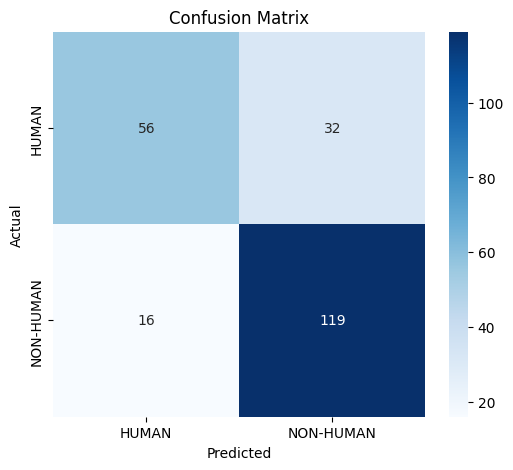

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_true = []
y_pred = []

for username, pred in results.items():
    if username in GROUND_TRUTH_BRANDS:
        y_true.append("NON-HUMAN")
    elif username in GROUND_TRUTH_CREATORS:
        y_true.append("HUMAN")
    else:
        continue 

    y_pred.append(pred)

cm = confusion_matrix(y_true, y_pred, labels=["HUMAN", "NON-HUMAN"])

TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]

print(f"TP: {TP} => Humans as Human")
print(f"FN: {FN} => Humans as Non-Human")
print(f"FP: {FP} => Non-Humans as Human")
print(f"TN: {TN} => Non-Humans as Non-Human")

print("\nAccuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["HUMAN", "NON-HUMAN"]))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HUMAN", "NON-HUMAN"], yticklabels=["HUMAN", "NON-HUMAN"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [5]:
false_positives = []
false_negatives = []

for username, predicted in results.items():
    if username in GROUND_TRUTH_CREATORS and predicted == "NON-HUMAN":
        false_negatives.append(username)
    elif username in GROUND_TRUTH_BRANDS and predicted == "HUMAN":
        false_positives.append(username)

print("\nFalse Negatives (Humans => Non-Humans):", false_negatives)
print("\nFalse Positives (Non-Humans => Humans):", false_positives)



False Negatives (Humans => Non-Humans): ['__.anuraaag', '__estrellaaaa.__', '__lil.jannat', '___notyourcupoftea___', '__ishikasachdeva__', '_.nickyy75_', '___antara__ghosh___', '_.mile.y', '__.aaddyyyyyyyy', '_.hett', '__barbie_grl', '___aamu___05', '___dhanu07___', '_.minney__06', '__.mitara.b.__', '___simran__official___', '__.shammu_zz', '_.harshitha_.gowda._', '_.shrush_', '__jess_mavalia__', '__ishannnnn._', '__.soulzy', '___maxumilian___', '__.sannss', '__beauty__squad__', '_.priyanshiii01', '___twinkling___', '__hussainujjain', '__baruah__96', '_.srilakshmi.__']

False Positives (Non-Humans => Humans): ['staywrogn', 'biotique_world', 'bobbibrownindia', 'crayy.heads', 'myskinq', 'siyaramsindia', 'dermabayskincare', 'skinkraftshop', 'maincharacter_india', 'shopaamili', 'coloressenceofficial', 'layrrd', 'auliglow']


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

def inspect(username):
    embeddings_file = os.path.join(COLLAB_DIR, username, "embeddings_output.npz")
    if not os.path.exists(embeddings_file):
        print(f"\nNo embeddings file for {username}")
        return
    
    data = np.load(embeddings_file, allow_pickle=True)
    profile_embeddings = data["profile_embeddings"]  
    thumbnail_embeddings = data["thumbnail_embeddings"]

    if thumbnail_embeddings.size == 0:
        print(f"\nNo thumbnail embeddings for {username}")
        return

    thumbnail_embeddings = np.array([normalize(e) for e in thumbnail_embeddings])

    clustering = DBSCAN(
        eps=0.5, 
        min_samples=2, 
        metric="cosine"
    ).fit(thumbnail_embeddings)

    labels = clustering.labels_
    clusters = defaultdict(list)
    for i, label in enumerate(labels):
        if label != -1:
            clusters[label].append(thumbnail_embeddings[i])

    centroids = {cid: np.mean(vectors, axis=0) for cid, vectors in clusters.items()}

    print(f"\n=====> {username}")
    print(f"Total thumbnails: {len(thumbnail_embeddings)}")
    print(f"Clusters found: {len(clusters)}")

    total_faces = len(thumbnail_embeddings)
    for cid, vectors in clusters.items():
        face_ratio = len(vectors) / total_faces
        cluster_ratio = len(vectors) / sum(len(v) for v in clusters.values())
        print(f"-Cluster {cid}: {len(vectors)} faces "
              f"(face_ratio={face_ratio:.2f}, cluster_ratio={cluster_ratio:.2f})")

        if profile_embeddings.size > 0:
            profile_vec = normalize(profile_embeddings[0])
            sim = cosine_similarity([profile_vec], [centroids[cid]])[0, 0]
            print(f"     => similarity to profile: {sim:.3f}")
        else:
            print("     => no profile embedding available")

print("\n=== False Negatives ===")
for u in false_negatives:
    inspect(u)

print("\n=== False Positives ===")
for u in false_positives:
    inspect(u)



=== False Negatives ===

=====> __.anuraaag
Total thumbnails: 13
Clusters found: 1
-Cluster 0: 10 faces (face_ratio=0.77, cluster_ratio=1.00)
     => similarity to profile: 0.217

=====> __estrellaaaa.__
Total thumbnails: 11
Clusters found: 2
-Cluster 0: 7 faces (face_ratio=0.64, cluster_ratio=0.78)
     => similarity to profile: 0.520
-Cluster 1: 2 faces (face_ratio=0.18, cluster_ratio=0.22)
     => similarity to profile: 0.330

=====> __lil.jannat
Total thumbnails: 54
Clusters found: 3
-Cluster 0: 2 faces (face_ratio=0.04, cluster_ratio=0.25)
     => no profile embedding available
-Cluster 1: 4 faces (face_ratio=0.07, cluster_ratio=0.50)
     => no profile embedding available
-Cluster 2: 2 faces (face_ratio=0.04, cluster_ratio=0.25)
     => no profile embedding available

=====> ___notyourcupoftea___
Total thumbnails: 29
Clusters found: 2
-Cluster 0: 3 faces (face_ratio=0.10, cluster_ratio=0.20)
     => similarity to profile: 0.021
-Cluster 1: 12 faces (face_ratio=0.41, cluster_rati

In [ ]:
import numpy as np
from itertools import product
from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Helper ---
def normalize(vec):
    norm = np.linalg.norm(vec)
    return vec / norm if norm > 0 else vec

# --- Pipeline ---
def run_pipeline(eps, min_samples, cos_sim, face_ratio, cluster_ratio, embeddings, profile_embeddings):
    thumbnails = np.array([normalize(e) for e in embeddings])

    # Cluster thumbnails
    db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
    labels = db.fit_predict(thumbnails)

    # Group clusters
    clusters = defaultdict(list)
    for i, lbl in enumerate(labels):
        if lbl != -1:
            clusters[lbl].append(thumbnails[i])

    if not clusters:
        return "NON-HUMAN"  # No clusters → non-human

    # Compute centroids
    centroids = {cid: np.mean(vectors, axis=0) for cid, vectors in clusters.items()}

    # Match clusters to profile embedding if available
    if profile_embeddings is not None and len(profile_embeddings) > 0:
        profile_vec = normalize(profile_embeddings[0])
        sims = {cid: cosine_similarity([profile_vec], [cent])[0, 0] for cid, cent in centroids.items()}
        best_clusters = [cid for cid, sim in sims.items() if sim > cos_sim]
    else:
        best_clusters = list(clusters.keys())

    if len(best_clusters) == 1:
        cid = best_clusters[0]
        total_faces = len(thumbnails)
        face_ratio_calc = len(clusters[cid]) / total_faces
        cluster_ratio_calc = len(clusters[cid]) / sum(len(v) for v in clusters.values())
        return "HUMAN" if (face_ratio_calc >= face_ratio and cluster_ratio_calc >= cluster_ratio) else "NON-HUMAN"
    else:
        return "NON-HUMAN"

# --- Grid Search ---
eps_values = [0.3, 0.4, 0.5, 0.6]
min_samples_values = [2, 3, 4]
cos_sim_values = [0.7, 0.8, 0.9]
face_ratios = [0.3, 0.4]
cluster_ratios = [0.3, 0.4]

best_params = None
best_acc = 0
results = []

param_combos = list(product(eps_values, min_samples_values, cos_sim_values, face_ratios, cluster_ratios))
total_combos = len(param_combos)

for idx, (eps, min_samples, cos_sim, face_ratio, cluster_ratio) in enumerate(param_combos, 1):
    print(f"Testing combo {idx}/{total_combos} -> eps={eps}, min_samples={min_samples}, cos_sim={cos_sim}, "
          f"face_ratio={face_ratio}, cluster_ratio={cluster_ratio}")

    # Build predictions for all users
    preds = []
    for emb, prof in zip(thumbnail_embeddings, profile_embeddings):
        preds.append(run_pipeline(eps, min_samples, cos_sim, face_ratio, cluster_ratio, emb, prof))

    acc = accuracy_score(y_true, preds)
    results.append((acc, eps, min_samples, cos_sim, face_ratio, cluster_ratio))

    if acc > best_acc:
        best_acc = acc
        best_params = (eps, min_samples, cos_sim, face_ratio, cluster_ratio)
        print(f"⭐ New best acc={best_acc:.3f} with {best_params}")

# --- Final Results ---
results.sort(reverse=True)
print("\n=== Top 5 Results ===")
for r in results[:5]:
    print(f"Acc={r[0]:.3f}, eps={r[1]}, min_samples={r[2]}, cos_sim={r[3]}, face_ratio={r[4]}, cluster_ratio={r[5]}")

print("\n=== Best Parameters ===")
print(f"Accuracy: {best_acc:.3f}")
print(f"Params: eps={best_params[0]}, min_samples={best_params[1]}, cos_sim={best_params[2]}, "
      f"face_ratio={best_params[3]}, cluster_ratio={best_params[4]}")

# --- Report for Best ---
best_eps, best_min_samples, best_cos, best_face, best_cluster = best_params
best_preds = [
    run_pipeline(best_eps, best_min_samples, best_cos, best_face, best_cluster, emb, prof)
    for emb, prof in zip(thumbnail_embeddings, profile_embeddings)
]

print("\n=== Classification Report for Best Parameters ===")
print(classification_report(y_true, best_preds, target_names=["HUMAN", "NON-HUMAN"]))
print(confusion_matrix(y_true, best_preds))


Testing combo 1/144 -> eps=0.3, min_samples=2, cos_sim=0.7, face_ratio=0.3, cluster_ratio=0.3


ValueError: Found input variables with inconsistent numbers of samples: [221, 0]